# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# Check the present working directory
!pwd

/Users/bukolaolumoyin/Documents/CustomerSegmentation


### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


In [2]:
# import libraries
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

In [1]:
import requests
import tarfile
import os


def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)



Download completed.
Extracting the file...
Extraction completed.
Downloaded tar.gz file removed.



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [1]:
# import libraries here; add more as necessary
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  
from custom_cleaning_transformer import DataSetCleaner
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

In [2]:
# load in the data
# column 18 and 19 had mixed datatypes so it is safe to bring them in as strings
dtype_dict = {'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015': str}
azdias_original = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';',
                              dtype=dtype_dict)
customers_original = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';',
                                 dtype=dtype_dict)
# import the wlb worksheet with created for converting CAMEO_DEU_2015 to float
df_wlb = pd.read_excel('work_life_balance.xlsx', header=1)
# create a dictionary from the wlb dataframe
wlb_dict = dict(zip(df_wlb['wlb_code'], df_wlb['category_value']))

In [3]:
# explore azdias dataset
azdias_original.sample(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
886265,374790,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
836971,397555,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,5.0,...,1.0,10.0,13.0,10.0,3.0,9.0,3.0,3,2,4
352306,917115,-1,6.0,17.0,NaN,NaN,NaN,NaN,17.0,6.0,...,4.0,10.0,6.0,3.0,4.0,7.0,7.0,5,2,4
765097,473787,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
564308,755149,-1,1.0,15.0,NaN,NaN,NaN,NaN,15.0,14.0,...,3.0,5.0,8.0,7.0,4.0,7.0,1.0,6,2,3
185669,1012229,1,1.0,0.0,NaN,NaN,NaN,NaN,13.0,1.0,...,2.0,2.0,4.0,4.0,5.0,9.0,7.0,1,1,3
855788,455020,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,10.0,11.0,8.0,4.0,9.0,7.0,3,1,3
3423,357027,1,1.0,17.0,NaN,NaN,NaN,NaN,11.0,6.0,...,1.0,2.0,4.0,2.0,NaN,9.0,4.0,3,1,4
589240,420232,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,9.0,9.0,6.0,6.0,9.0,8.0,2,1,4
472736,1064018,-1,1.0,21.0,NaN,NaN,NaN,NaN,21.0,1.0,...,1.0,2.0,3.0,5.0,3.0,9.0,2.0,2,2,2


In [4]:
# explore customers dataset
customers_original.sample(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
38203,156649,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,...,8.0,5.0,8.0,5.0,4,COSMETIC_AND_FOOD,MULTI_BUYER,1,1,3
191634,55811,2,1.0,18.0,NaN,NaN,NaN,NaN,12.0,2.0,...,1.0,2.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,1,1,3
31136,19237,2,1.0,16.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
25205,91642,2,9.0,0.0,NaN,NaN,NaN,NaN,5.0,3.0,...,1.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
77572,22414,3,1.0,0.0,NaN,NaN,NaN,NaN,7.0,0.0,...,3.0,NaN,9.0,2.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,1
173226,18204,2,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,7.0,3,FOOD,MULTI_BUYER,0,1,3
27393,108369,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,1
99875,146801,-1,1.0,0.0,NaN,NaN,NaN,NaN,18.0,1.0,...,3.0,2.0,9.0,2.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,2
187122,135782,-1,1.0,8.0,NaN,NaN,NaN,NaN,0.0,1.0,...,6.0,6.0,9.0,7.0,3,FOOD,MULTI_BUYER,0,2,4
141865,11875,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,FOOD,MULTI_BUYER,1,1,3


In [5]:
# ensure data completeness
azdias_original.shape, customers_original.shape

((891221, 366), (191652, 369))

### Data Cleaning
As much as possible we want to make our data numeric instead of strings. In this section, we will clean all string columns, 
replacing them with numeric values where possible. We will use the functions belows to help with cleaning our data. We have explained the steps here:
- Remove columns with more that 50% NAN values
- Generate IDs
- Remove Duplicates
- Convert string categorical columns to floats

##### List all string columns
To be able to successfully extract relevant features, we need to have our data as numeric. 
The column names below have string values. We will convert columns with categorical values to numeric first while 
we inspect other non categorical columns
- CAMEO_DEU_2015: Work-Life-Balance (Categorical)
- CAMEO_DEUG_2015:Income Group (Categorical)
- OST_WEST_KZ: GDR/FRG (Categorical)
- CAMEO_INTL_2015
- D19_LETZTER_KAUF_BRANCHE
- EINGEFUEGT_AM
- PRODUCT_GROUP
- CUSTOMER_GROUP

We will write a function that takes a dataframe, a column name and a dictionary. The function will return the dataframe with the specified column value as float.
The work-Life-Balance column has several categories, we are going to use a csv file to create a dictionary for that while we create others by hand

##### Generate IDs for all rows
It does not appear that the data has an ID to uniquely identify rows, as a result, we will generate IDs for our records. 
This is solely for us to be able to regenerate our original records from segmented general poupulation data.
We will generate unique IDs for azdias dataframe. We chose 0s for customers IDs since the ids are there just to match the columns on azdias dataframe.

In [6]:
# we need to generate Ids while the data is still in its original form.
# That way we can trace back our segmented data
azdias_original['row_number'] = azdias_original.index
customers_original['row_number'] = 0

In [7]:
azdias_original['row_number']

0              0
1              1
2              2
3              3
4              4
           ...  
891216    891216
891217    891217
891218    891218
891219    891219
891220    891220
Name: row_number, Length: 891221, dtype: int64

In [8]:
# Let us checks our dataframes for any object column. None is expected
customers_str = customers_original.select_dtypes(include=object)
azdias_str = azdias_original.select_dtypes(include=object)
customers_str.columns, azdias_str.columns

(Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
        'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
        'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
       dtype='object'),
 Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
        'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
       dtype='object'))

In [9]:
def display_NAN_distribution(df):
    '''
    INPUT - df - pandas dataframe with NAN across rows and columns
    '''    
    nan_percentage_col = df.isna().mean() * 100
    nan_percentage_row = df.isna().mean(axis=1) * 100
    # Step 2: Count columns that fall into specific NaN percentage categories
    bins = [0, 25, 50, 75, 100]  # Define the percentage bins
    
    nan_groups_cols = pd.cut(nan_percentage_col, bins=bins)  # Group columns based on NaN percentage ranges
    nan_group_counts_cols = nan_groups_cols.value_counts().sort_index()
    
    nan_groups_rows = pd.cut(nan_percentage_row, bins=bins)  # Group columns based on NaN percentage ranges
    nan_group_counts_rows = nan_groups_rows.value_counts().sort_index()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    nan_group_counts_cols.plot(kind='bar', color='skyblue', ax = axes[0])
    plt.xticks(rotation=45, horizontalalignment="center")
    axes[0].set_title('Number of Columns by Percentage of Missing Values', fontsize=10)
    axes[0].set_xlabel('Percentage of NaN Values')
    axes[0].set_ylabel('Number of Columns')
    
    nan_group_counts_rows.plot(kind='bar', color='skyblue', ax = axes[1])
    plt.xticks(rotation=45, horizontalalignment="center")
    axes[1].set_title('Number of Rows by Percentage of Missing Values', fontsize=10)
    axes[1].set_xlabel('Percentage of NaN Values')
    axes[1].set_ylabel('Number of Rows')
    plt.show()

In [10]:
def get_columns_with_majority_NAN(df):
    missing_percentage = df.isna().mean()
    # Select columns where more than 75% of the data is NaN
    columns_with_75_percent_nan = missing_percentage[missing_percentage > 0.75].index
    return list(columns_with_75_percent_nan)

In [11]:
def drop_rows_with_majority_NAN(df):
    missing_percentage_per_row = df.isna().mean(axis=1)
    # Select rows where more than 75% of the data is NaN
    # Drop rows where more than 50% of the data is NaN
    df_cleaned = df[missing_percentage_per_row <= 0.50]
    return df_cleaned

In [12]:
def preprocess_df_column(df, column, nan_value=None, str_to_replace=None,
                         replacement_str=None, rpl_dict=None):
    """ 
        DESC: preprocesses dataframe replacing NAN with appropriate values
        INPUT: df - a dataframe to be cleaned
               column - a dataframe column to be cleaned
               nan_value: a replacement value for NAN values
               str_to_replace: a sting to be replace
               replacement_str: A replacement string
               rpl_dict: A dictionary for replacement
        OUTPUT: a clean dataframe
    """
    if nan_value:
        df[column] = df[column].fillna(nan_value)
    if str_to_replace:
        df[column].replace(str_to_replace, replacement_str, inplace=True)
    if rpl_dict:
        df = convert_categories_to_int(df, column, rpl_dict)
    df = df.astype({column:'float'})
    return df

In [13]:
def convert_categories_to_int(df, column, category_dict):
    """
        DESC: converts a dataframe column content from string to int
        INPUT: df - dataframe containing data
               column - dataframe column
               category_dict - dictionary with keys are strings to
               be converted and values as replacement number
        OUTPUT: a dataframe with specified column converted to int
    """
    df[column] = df[column].replace(category_dict)
    return df

In [14]:
def clean_data(df, df_wlb, has_extras=False):
    """
        DESC: cleans a dataframe
        INPUT: df - dataframe containing data
               df_wlb - a dictionary that contains replacement values for a column
               has_extras - a boolean to check if a dataframe has extra columns
        OUTPUT: a dataframe with specified column converted to int
    """
    # remove duplicates
    df.drop_duplicates(keep='first', inplace=True)
    # get and drop columns with majority NAN
    df_clean = drop_rows_with_majority_NAN(df)
    # get and drop columns with majority NAN
    nan_columns = get_columns_with_majority_NAN(df_clean)
    df_clean.drop(nan_columns, axis=1, inplace=True)
    # replace string values with floats
    # Convert CAMEO_DEUG_2015 to float
    df = preprocess_df_column(df_clean, 'CAMEO_DEUG_2015', 0, 'X', '-1')
    # Convert CAMEO_DEU_2015 to float
    wlb_dict = dict(zip(df_wlb['wlb_code'], df_wlb['category_value']))
    df = preprocess_df_column(df, 'CAMEO_DEU_2015', 0, 'XX', '-1', wlb_dict)
    # Convert CAMEO_INTL_2015 to float
    df = preprocess_df_column(df, 'CAMEO_INTL_2015', 0, 'XX', '-1')
    # Convert OST_WEST_KZ to float
    gdr_frg = {'O': 0, 'W': 1}
    df = preprocess_df_column(df, 'OST_WEST_KZ', 0, rpl_dict=gdr_frg)
    if has_extras:
        # Convert PRODUCT_GROUP to float
        prdt_grp = {'FOOD': 1, 'COSMETIC': 2, 'COSMETIC_AND_FOOD': 3}
        df = preprocess_df_column(df, 'PRODUCT_GROUP', rpl_dict=prdt_grp)
        # Convert Customer CUSTOMER_GROUP to float
        cust_grp = {'MULTI_BUYER': 1 , 'SINGLE_BUYER': 2}
        df = preprocess_df_column(df, 'CUSTOMER_GROUP', 0, rpl_dict=cust_grp)
    # Most of our columns should now have numeric values. We will drop the ones that do not have float values
    # We have identified the two columns: 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM'
    # The column EINGEFUEGT_AM contains timestamp in string format, we will extract the year and drop the other column
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    df['EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].dt.year
    df.drop(['D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)
    return df     

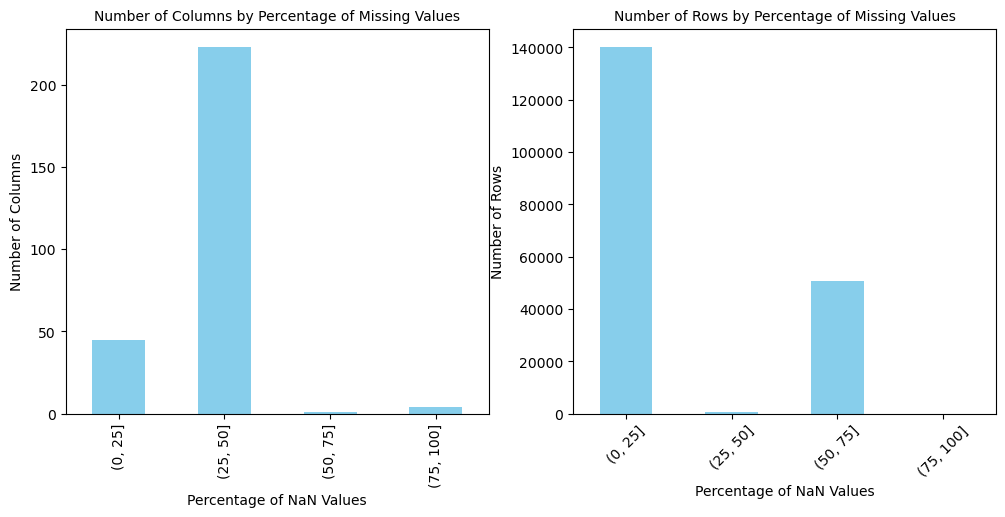

In [15]:
display_NAN_distribution(customers_original)

In [16]:
customers = clean_data(customers_original, df_wlb, has_extras=True)
azdias = clean_data(azdias_original, df_wlb)

/var/folders/t7/jqmr0_p12vj_nvw4t_6wmsf00000gn/T/ipykernel_96923/2727407309.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(nan_columns, axis=1, inplace=True)
/var/folders/t7/jqmr0_p12vj_nvw4t_6wmsf00000gn/T/ipykernel_96923/2643539297.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].replace(str_to_replace, replacement_str, inplace=True)
/var/folders/t7/jqmr0_p12vj_nvw4t_6wmsf00000gn/T/ipykernel_96923/2727407309.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [17]:
customers.shape, azdias.shape, customers_original.shape, azdias_original.shape

((140904, 365), (791990, 362), (191652, 370), (891221, 367))

In [18]:
# Let us checks our dataframes for any object column. None is expected
customers_str = customers.select_dtypes(include=object)
azdias_str = azdias.select_dtypes(include=object)
customers_str.columns, azdias_str.columns

(Index([], dtype='object'), Index([], dtype='object'))

In [19]:
# remove the three extra columns from customers. We want to make the two dataframes have the same column number
customers.drop(['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
               axis=1, inplace=True)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Feature Relevance
In this section, we would extract relevant features from our dataframe. Let us explore some methods to use

- Variance Threshold
- Correlation Matrix
- Unsupervised Random Forest (using feature importance)

We will compare the results we get from this method and then decide on features we want to use. It is a good idea to create a copy of our dataframe before implementing any of these feature relevance techniques


#### Variance Threshold
Features with low variance are often less informative because they don't vary much across observations. We can eliminate features that have very little variability.

In [20]:
customers_df = customers.copy()
azdias_df = azdias.copy()

In [21]:
def get_irrelevant_features(X):
    """
        DESC: A function to get least relevant features in a dataframe
        INPUT: A dataframe with numerous features
        OUTPUT: An array that contains least relevant features in a dataframe
    """
    # Step 1: Scaling the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Step 2: Applying Variance Threshold
    # Set a threshold value (e.g., 0.01 for low variance features)
    threshold_value = 0.1
    selector = VarianceThreshold(threshold=threshold_value)
    X_reduced = selector.fit_transform(X_scaled)
    
    # Step 3: Convert back to DataFrame (optional) for easy viewing
    X_reduced_df = pd.DataFrame(X_reduced, columns=X.columns[selector.get_support()])
    all_features = X.columns.values
    # find the difference
    irrelevant_features = list(set(all_features) - set(X_reduced_df.columns.values))
    return irrelevant_features

In [22]:
irrelevant_features = get_irrelevant_features(customers_df)

In [23]:
irrelevant_features

['row_number']

In [24]:
# let us drop these columns from our dataframe
# notice how 'row number' is part of the irrelevant features. We will exclude the row number from the list of irrelevant features since we still need it
irrelevant_features = [x for x in irrelevant_features if x != 'row_number']
customers_df.drop(irrelevant_features,axis=1, inplace=True)
azdias_df.drop(irrelevant_features,axis=1, inplace=True)


#### Correlation Matrix
- Compute the correlation matrix between features to identify highly correlated features (which can be redundant).
- Remove one of the features in each pair of highly correlated features (e.g., with a correlation above 0.9)

In [25]:
customers_df1 = customers_df.copy()
azdias_df1 = azdias_df.copy()

In [26]:
def get_redundant_features(df):
    """
    DESC: A function to get redundant features in a dataframe
    INPUT: A dataframe with numerous features
    OUTPUT: An array that contains redundant features in a dataframe
    """
    corr_matrix = pd.DataFrame(df).corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    redundant_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
    return redundant_features

In [27]:
redundant_features = get_redundant_features(customers_df1)
len(redundant_features)

36

In [28]:
# let us drop these columns from our dataframe
customers_df1.drop(redundant_features, axis=1, inplace=True)
azdias_df1.drop(redundant_features, axis=1, inplace=True)

#### Unsupervised Random Forest (using feature importance)
Instead of using IsolationForest, you can apply a Random Forest in an unsupervised setting by treating it as a clustering algorithm and then using the feature_importances_ attribute.

Steps:
- Convert the problem into a pseudo-supervised task.
- Train a Random Forest 
- Extract feature importances.

We need to replace Nan with -1. The choice of this value is based on what we observed from the data dictionary. For most columns, "unknown" values are represented with -1.

In [29]:
# how many columns have a null value
nan_columns = customers_df1.columns[customers_df1.isna().any()].tolist()
len(nan_columns)

215

In [30]:
# convert all null values to -1
customers_df1 = customers_df1.fillna(-1)
azdias_df1 = azdias_df1.fillna(-1)
customers_df2 = customers_df1.copy()
azdias_df2 = azdias_df1.copy()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

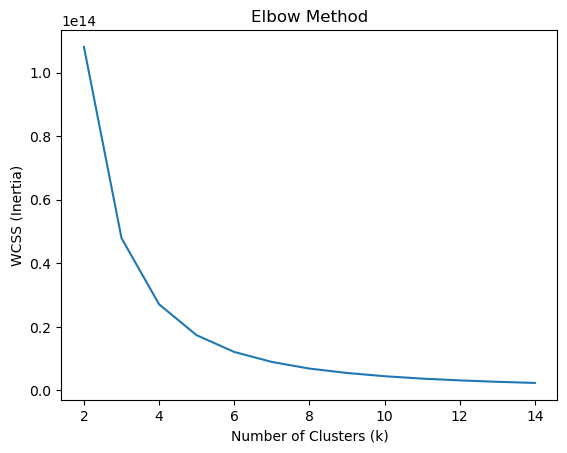

In [31]:
# Range of k values to test for an appropriate cluster
wcss = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(customers_df2)  # X is your feature matrix
    wcss.append(kmeans.inertia_)

# Plotting the results to find the elbow point
plt.plot(range(2, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.show()

In [32]:
def reduce_df_to_100_features(df, k):
    """
    DESC: A function to get the most relevant 100 features in a dataframe
    INPUT: df - A dataframe with numerous features
           k - number of cluster
    OUTPUT: An array that contains redundant features in a dataframe
    """
     # Step 1: Load and preprocess your dataset (df without labels)
    df_original = df.copy()
    
    # Step 2: Create synthetic data by shuffling the original dataset
    df_synthetic = df_original.apply(np.random.permutation)
    
    # Step 3: Concatenate real and synthetic data, and label them
    df_combined = pd.concat([df_original, df_synthetic], axis=0)
    labels = np.array([0] * df_original.shape[0] + [1] * df_synthetic.shape[0])
    
    # Step 4: Train an Unsupervised Random Forest (RFC as binary classifier) to distinguish real from synthetic data
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(df_combined, labels)
    
    # Step 5: Extract feature importance from the Random Forest
    feature_importances = clf.feature_importances_
    
    # Step 6: Sort and select top N important features
    top_n = 100  # Number of top features to keep (adjust based on your needs)
    important_features = np.argsort(feature_importances)[::-1][:top_n]
    df_reduced = df_original.iloc[:, important_features]
    return df_reduced



In [33]:
reduced_data = reduce_df_to_100_features(customers_df2, k=6)
# notice how row number is  in our selected features
top_100_features = list(reduced_data.columns.values)
# add the row_number into the top features for easy tracking of records
top_100_features.append('row_number')


In [34]:
# aply selected features to dataframe
customers_df3 = customers_df2[top_100_features]
azdias_df3 = azdias_df2[top_100_features]

In [35]:
customers_df3.shape, azdias_df3.shape

((140904, 101), (791990, 101))

Now that we have formatted our dataframes with top 100 relevant features, we can now start the process of customer segmentation

#### K-Means Clustering
We will use clustering methods like K-Means to group similar features and then select representative features from each cluster. 
To get an appropriate number of clusters needed for our data set, we will use the elbow method.

In the section below, we will find members of the general population (contained in azdias dataframe) that have similar features to the customers population (contained in customers dataframe). We will be using K-Means clustering. With this method, we would group rows from both customers and azdias dataframes and then identify which rows from azdias(general population) dataframe fall into clusters that also contain rows from customers dataframe. The steps are listed below:

- Combine azdiaz(general population) and customers dataframe: Our data cleaning section makes this possible to do since there are now the same number of columns and data types in both dataframes.
- Apply K-Means Clustering
- Identify clusters that contain rows from both populations
- Select rows from azdias dataframe (general population) that are in the same clusters as the customers dataframe


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

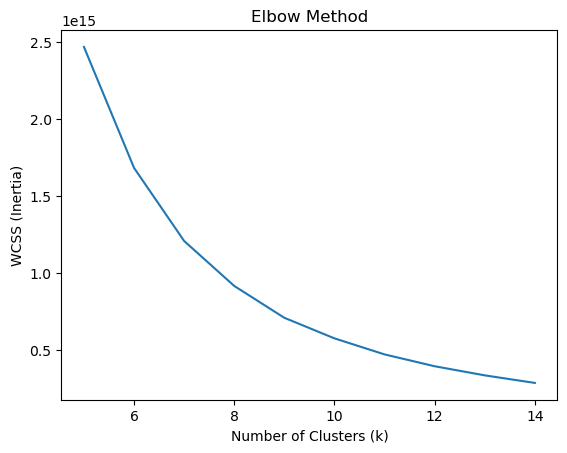

In [36]:
# step 1 Combine azdiaz(general population) and customers dataframe
all_population = pd.concat([azdias_df3, customers_df3], ignore_index=True)
# Range of k values to test
wcss = []
for i in range(5, 15):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(all_population)  # X is your feature matrix
    wcss.append(kmeans.inertia_)

# Plotting the results to find the elbow point
plt.plot(range(5, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.show()

In [37]:
def get_segmented_population(all_population_df, target_population_df, k):
    """
    DESC: A function to get a segmented population from a general population
    INPUT: all_population_df - General population dataframe
           target_population_df - population with features similar to our segmented population
           k - number of cluster
    OUTPUT: An array that contains segmented population
    """
    # k = 10 # based on the graph above
    # step 2 Apply Kmeans Clustering
    kmeans = KMeans(n_clusters=k)
    all_population_df['cluster'] = kmeans.fit_predict(all_population_df)
    # step 3 Find clusters containing customers data
    clusters_with_customers = set(all_population_df.iloc[len(target_population_df):]['cluster'])
    # step 4 Select rows from azdias dataframe (general population) in the same clusters
    segmented_population = all_population_df.loc[(all_population_df.index < len(target_population_df))
                        & (all_population_df['cluster'].isin(clusters_with_customers))]
    return segmented_population

In [39]:
segmented_population = get_segmented_population(all_population, azdias_df3,  k=10)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [40]:
segmented_population.shape

(46654, 102)

In [41]:
segmented_population

,D19_GESAMT_DATUM,ANZ_HAUSHALTE_AKTIV,ALTERSKATEGORIE_FEIN,CJT_TYP_4,KBA05_ANTG1,EWDICHTE,D19_GESAMT_ONLINE_DATUM,GEMEINDETYP,MOBI_REGIO,KBA13_ANTG3,...,SEMIO_LUST,CJT_TYP_6,AGER_TYP,KBA13_CCM_1000,KBA13_CCM_1401_2500,KBA05_KW1,KBA05_MOD1,KBA05_VORB0,row_number,cluster
0,10,11.0,21.0,3.0,0.0,3.0,10,22.0,1.0,2.0,...,2,1.0,-1,0.0,3.0,1.0,3.0,1.0,1,1
1,10,10.0,17.0,3.0,1.0,4.0,10,22.0,3.0,1.0,...,4,2.0,-1,1.0,3.0,3.0,0.0,4.0,2,1
2,10,1.0,13.0,4.0,4.0,2.0,10,40.0,4.0,1.0,...,4,3.0,2,4.0,2.0,3.0,2.0,2.0,3,1
3,1,3.0,14.0,4.0,1.0,5.0,1,21.0,3.0,2.0,...,4,3.0,-1,5.0,1.0,3.0,3.0,5.0,4,1
4,3,5.0,10.0,5.0,2.0,2.0,3,40.0,4.0,1.0,...,2,3.0,3,3.0,4.0,1.0,2.0,4.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46649,10,2.0,9.0,5.0,2.0,2.0,10,40.0,5.0,0.0,...,4,5.0,2,1.0,4.0,3.0,2.0,2.0,52143,1
46650,7,1.0,17.0,2.0,-1.0,3.0,7,30.0,-1.0,1.0,...,2,3.0,-1,0.0,3.0,-1.0,-1.0,-1.0,52144,1
46651,2,1.0,19.0,2.0,4.0,2.0,2,40.0,4.0,1.0,...,3,1.0,-1,2.0,4.0,3.0,1.0,2.0,52145,1
46652,9,2.0,13.0,4.0,-1.0,2.0,10,40.0,-1.0,0.0,...,4,3.0,2,3.0,4.0,-1.0,-1.0,-1.0,52146,1


Our K-Means clustering algorithm was able to identify approximately 46000 rows from the general population that share similar features 
with already existing customers. This accounts for approximaately 5% of the general population. Our client would be better off if they targeted this specific population than randomly targeting the entire population.


#### Returning original data for recommended customers
A new column was added to the recommended population, this is the cluster column. Our next step would be to reconstruct our recommendation data back to its original form. If we are going to hand over our data to the marketing department for example, they expect to see all the columns not juts 100 columns. This is where the IDs we introduced will become useful. We need to extract rows from the original dataframe that have same IDs as our recomendated population. We will use the following steps:
- extract IDs from recommended data
- Join with original data using the ID
- Export original recommended data as CSV

In [42]:
# step 1
row_nums_df = segmented_population['row_number']
# step 2
recommended_df = pd.merge(azdias_original, row_nums_df,
                          on='row_number', how='inner')


In [43]:
recommended_df.drop(columns=['row_number'], inplace=True)
recommended_df.shape

(46654, 366)

In [44]:
recommended_df.to_csv('recommended_customers.csv', index = False)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [3]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/var/folders/t7/jqmr0_p12vj_nvw4t_6wmsf00000gn/T/ipykernel_14863/2624572247.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [4]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/t7/jqmr0_p12vj_nvw4t_6wmsf00000gn/T/ipykernel_14863/4118961090.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [5]:
mailout_train.shape, mailout_test.shape

((42962, 367), (42833, 366))

In [6]:
# check that RESPONSE is binary
# our data is very unbalanced
mailout_train['RESPONSE'].value_counts()

RESPONSE
0    42430
1      532
Name: count, dtype: int64

In [7]:
# We clean our data before creating a model
X_train = mailout_train.drop('RESPONSE', axis = 1)
X_test = mailout_test
y_train = mailout_train['RESPONSE']
X_train.shape, X_test.shape, y_train.shape

((42962, 366), (42833, 366), (42962,))

##### Create a Model
We will explore the two classifiers to create our model
-  Random Forest Classifier
-  XGBoost


##### Random Forest Classifier
We will go through the following steps to create a model that we can use to make prediction on our test data
- Normalize data
- Handle Imbalance Dataset
- Train the Model
- Make predictions on test data

In [8]:
def build_model_rf():
    # create a model that will be used to train our data to make predictions
    model = ImbPipeline(steps=[
    ('cleaner', DataSetCleaner()), # step 1: data cleaning
    ('scaler', StandardScaler()),  # Sstep 2: Standard scaling
    ('smote', SMOTE(random_state=42)),  # step 3: SMOTE for oversampling minority class
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))  # step 4: Random Forest
])
    parameters = {
        'classifier__n_estimators': [20, 50, 100],
        'classifier__min_samples_split': [2, 4, 6],
        'classifier__min_samples_leaf': [1, 2, 5]
}

    # create grid search object
    #cv = GridSearchCV(model, param_grid=parameters)
    cv = GridSearchCV(estimator=model, param_grid=parameters, scoring='roc_auc', cv=5)

    
    return cv

In [9]:
model_rf = build_model_rf()
model_rf.fit(X_train, y_train)
# Output the best hyperparameters and AUC score
print("Best hyperparameters:", model_rf.best_params_)
print("Best AUC-ROC score from GridSearchCV:", model_rf.best_score_)


Best hyperparameters: {'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best AUC-ROC score from GridSearchCV: 0.6402906902831608


In [10]:
y_pred = model_rf.predict(X_test)
unique_values, counts = np.unique(y_pred, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 41410
Value: 1, Count: 1423


In [12]:
filename = 'model_rfc.pkl'
pickle.dump(model_rf, open(filename, 'wb'))

##### XGBoost
Similar to what we did in the first model but we will use XGBoostClassifier and make predictions on the test data

In [19]:
def build_model_xgb():
    # create a model that will be used to train our data to make predictions
    ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model = ImbPipeline(steps=[
    ('cleaner', DataSetCleaner()), # step 1: data cleaning
    ('scaler', StandardScaler()),  # step 2: Standard scaling
    ('smote', SMOTE(random_state=42)),  # step 3: SMOTE for oversampling minority class
    ('classifier', XGBClassifier(scale_pos_weight=ratio,  random_state=42))  # step 4: XGBoost Classifier
])
    # Define the parameter grid
    parameters = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7]
    }
    cv = GridSearchCV( estimator=model, param_grid=parameters, scoring='roc_auc')  

    return cv

In [20]:
model_xgb = build_model_xgb()
model_xgb.fit(X_train, y_train)
# Output the best hyperparameters and AUC score
print("Best hyperparameters:", model_xgb.best_params_)
print("Best AUC-ROC score from GridSearchCV:", model_xgb.best_score_)

Best hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best AUC-ROC score from GridSearchCV: 0.7113838852403825


In [18]:
y_pred = model_xgb.predict(X_test)
unique_values, counts = np.unique(y_pred, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 38543
Value: 1, Count: 4290


In [ ]:
filename = 'model_xgbc.pkl'
pickle.dump(model, open(filename, 'wb'))

XGBoostClassifier seems to have better predictions when data is unbalanced. XGBoost has a parameter called scale_pos_weight specifically designed to handle imbalanced datasets. This parameter adjusts the weight of the positive class, compensating for the class imbalance.